#### Important
Pour le fine-tuning çi contre, il faut utiliser un environnement différent de celui utilisé pour l'augmentation des données. Ici il faut les librairies avec les versions çi contre:

- transformers version: 4.41.2
- scikit-learn version: 1.7.1
- un environnement en python 3.12.8
- Torch version: 2.5.1+cpu
- torchvision version: 0.20.1+cu121
- torchaudio version: 2.5.1

In [4]:
import pandas as pd 

data = pd.read_csv("./data/data_final_phase2_private.csv")
data.head()

,text,tokens_clean,text_clean,type_article,thematique
0,Microbial Community Composition Associated wit...,"['microbial', 'community', 'composition', 'ass...",microbial community composition associated pot...,VS,SV
1,Plant Pathogenic and Endophytic Colletotrichum...,"['plant', 'pathogenic', 'endophytic', 'colleto...",plant pathogenic endophytic colletotrichum fru...,VS,SV
2,Lethal Bronzing: What you should know about th...,"['lethal', 'bronzing', 'know', 'disease', 'tur...",lethal bronzing know disease turn palm tree br...,VS,SV
3,Leaffooted Bug Damage in Almond Orchards Leaff...,"['leaffooted', 'bug', 'damage', 'almond', 'orc...",leaffooted bug damage almond orchard leaffoote...,VS,SV
4,Kebbi govt battles mysterious disease affectin...,"['kebbi', 'govt', 'battle', 'mysterious', 'dis...",kebbi govt battle mysterious disease affecting...,VS,SV


Classes: ['NVS', 'VS']


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/all-MiniLM-L6-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Device: cuda | CUDA=True | bf16=True | fp16=False


/home/rosalie/miniforge3/envs/sursy/lib/python3.12/site-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision Macro,Recall Macro
94,No log,0.216364,0.901606,0.533826,0.950472,0.531847
100,0.344600,No Log,No Log,No Log,No Log,No Log
188,0.344600,0.101056,0.965863,0.907427,0.915878,0.899416
200,0.170200,No Log,No Log,No Log,No Log,No Log
282,0.170200,0.084610,0.973896,0.934097,0.913820,0.957308
300,0.102100,No Log,No Log,No Log,No Log,No Log
376,0.102100,0.055469,0.981928,0.952359,0.948627,0.956174
400,0.067500,No Log,No Log,No Log,No Log,No Log
470,0.067500,0.047367,0.985274,0.961073,0.958519,0.963665
500,0.066400,No Log,No Log,No Log,No Log,No Log


/home/rosalie/miniforge3/envs/sursy/lib/python3.12/site-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/home/rosalie/miniforge3/envs/sursy/lib/python3.12/site-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/hom


Aperçu des courbes (par epoch):
    epoch  eval_loss  eval_accuracy  eval_f1_macro  train_loss  train_accuracy  \
0      1   0.233988       0.895582       0.490918    0.216364        0.901606   
1      2   0.136386       0.953815       0.871018    0.101056        0.965863   
2      3   0.142763       0.951807       0.882915    0.084610        0.973896   
3      4   0.128081       0.957831       0.891832    0.055469        0.981928   
4      5   0.131357       0.957831       0.891832    0.047367        0.985274   
5      6   0.140543       0.957831       0.895188    0.043630        0.983266   
6      7   0.135628       0.955823       0.889342    0.125896        0.989960   

   train_f1_macro  train_precision_macro  train_recall_macro  
0        0.533826               0.950472            0.531847  
1        0.907427               0.915878            0.899416  
2        0.934097               0.913820            0.957308  
3        0.952359               0.948627            0.956174  
4 

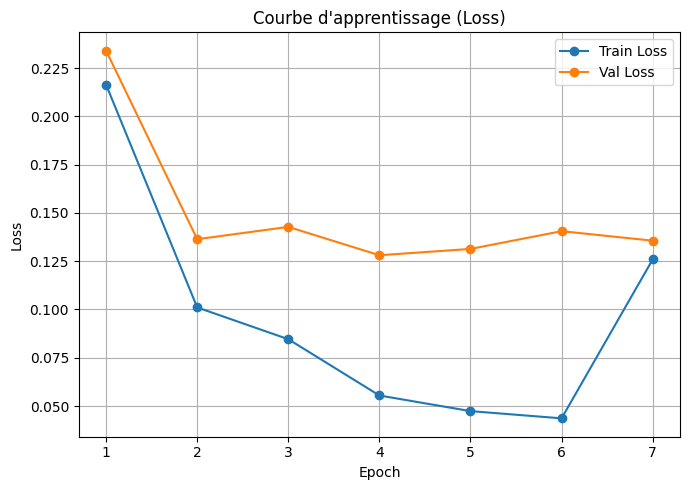

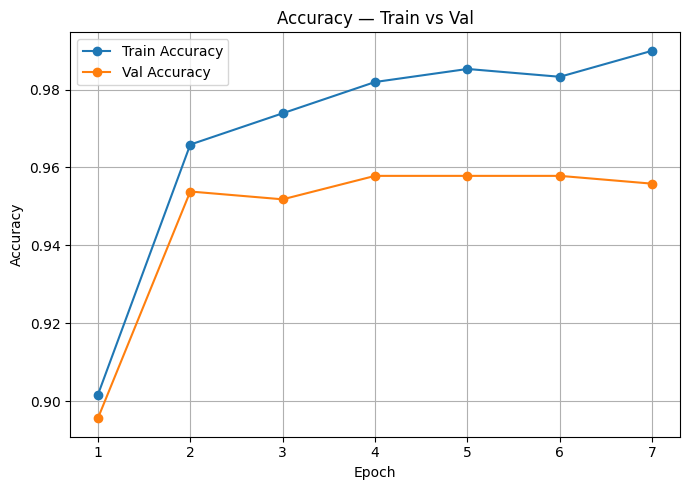

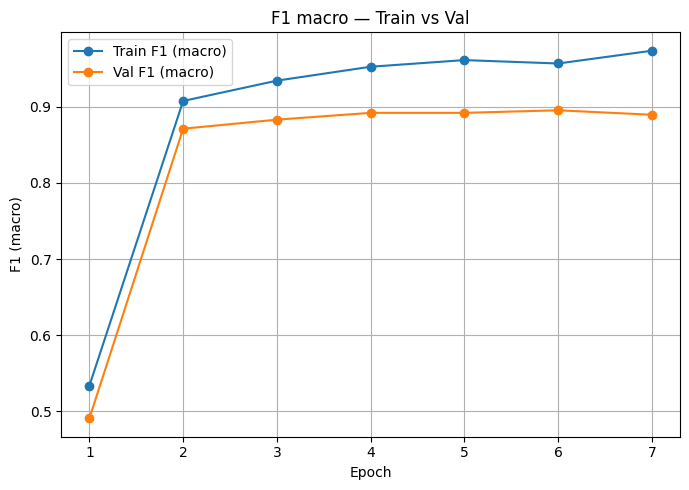


=== Rapport de classification (TEST) ===
              precision    recall  f1-score   support

         NVS       0.98      0.97      0.98       459
          VS       0.70      0.79      0.75        39

    accuracy                           0.96       498
   macro avg       0.84      0.88      0.86       498
weighted avg       0.96      0.96      0.96       498



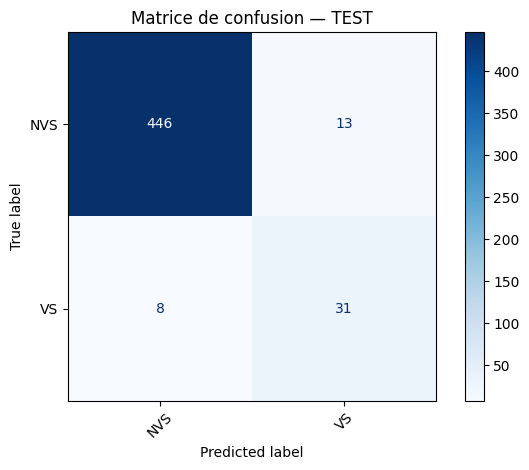

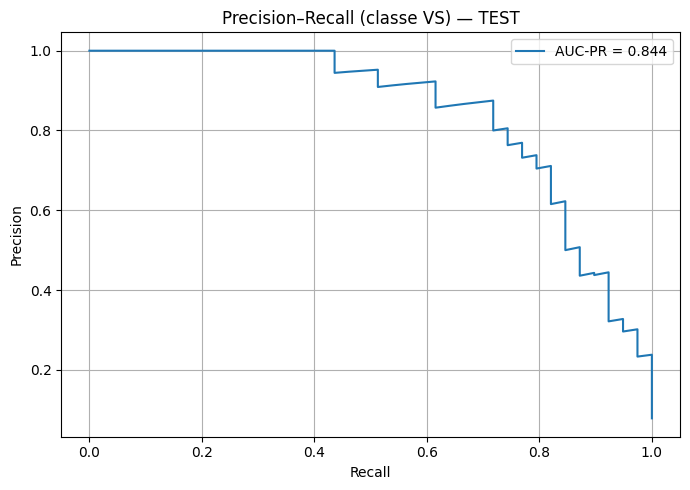


Best model saved to: ./results_SBERT/best_checkpoint (metric None with greater_is_better=None)


In [5]:
# =========================
# 0) Imports
# =========================
import os, json, joblib
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt


from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    precision_recall_curve, average_precision_score,
    f1_score, precision_score, recall_score, accuracy_score
)

from torch.utils.data import Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    Trainer, TrainingArguments, TrainerCallback
)

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

os.environ["TRANSFORMERS_NO_TORCHVISION"] = "1"


SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# GPU / précision (Ada -> bf16 recommandé)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_bf16 = torch.cuda.is_available() and torch.cuda.is_bf16_supported()
use_fp16 = torch.cuda.is_available() and not use_bf16

try:
    torch.set_float32_matmul_precision("high")
except Exception:
    pass


# =========================
# 1) Données + indices sauvegardés
# =========================
from sklearn.model_selection import train_test_split

X_all = data["text"].astype(str).to_numpy()
y_all = data["type_article"].to_numpy()

# Encodage labels
label_encoder = LabelEncoder()
y_enc = label_encoder.fit_transform(y_all)
num_classes = len(label_encoder.classes_)
print("Classes:", list(label_encoder.classes_))

# Division 60% train, 20% val, 20% test 
X_train, X_temp, y_train, y_temp = train_test_split(X_all, y_enc, test_size=0.4, shuffle=True, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=True, random_state=42)


# =========================
# 2) Tokenizer & modèle
# =========================
model_name = "sentence-transformers/all-MiniLM-L6-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_classes,
    torch_dtype=(torch.bfloat16 if use_bf16 else None),  # bf16
).to(device)


# =========================
# 3) Dataset PyTorch (robuste)
# =========================
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256):
        if isinstance(texts, np.ndarray):
            texts = texts.tolist()
        self.texts = [
            "" if (t is None or (isinstance(t, float) and np.isnan(t))) else str(t)
            for t in texts
        ]
        self.encodings = tokenizer(self.texts, truncation=True, padding=True, max_length=max_length)
        self.labels = labels.tolist() if isinstance(labels, np.ndarray) else list(labels)
        assert len(self.texts) == len(self.labels)

    def __len__(self): 
        return len(self.labels)

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

train_ds = TextDataset(X_train, y_train, tokenizer)
val_ds   = TextDataset(X_val,   y_val,   tokenizer)
test_ds  = TextDataset(X_test,  y_test,  tokenizer)

# =========================
# 4) Metrics + Callback TrainEval
# =========================
def compute_metrics(eval_pred):
    # Compat: EvalPrediction (HF récent) ou tuple (anciens)
    if hasattr(eval_pred, "predictions"):
        logits = eval_pred.predictions
        labels = eval_pred.label_ids
    else:
        logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro"),
        "precision_macro": precision_score(labels, preds, average="macro", zero_division=0),
        "recall_macro": recall_score(labels, preds, average="macro", zero_division=0),
    }

from transformers import TrainerCallback
import math, os

class ValEvalAndEarlyStopCallback(TrainerCallback):
    """
    - Évalue sur le set de validation à la fin de chaque epoch
    - Loggue les métriques 'eval_*' dans log_history
    - Early stopping custom basé sur training_args.metric_for_best_model et greater_is_better
    - Sauvegarde le meilleur modèle dans output_dir/best_checkpoint
    """
    def __init__(self, trainer, patience=3):
        self.trainer = trainer
        self.patience = patience
        self.best_metric = None
        self.best_epoch = None
        self.bad_epochs = 0
        self.best_dir = os.path.join(str(trainer.args.output_dir), "best_checkpoint")
        os.makedirs(self.best_dir, exist_ok=True)

        # lit la config d'arrêt
        self.metric_name = trainer.args.metric_for_best_model or "eval_loss"
        self.greater_is_better = bool(trainer.args.greater_is_better)

    def _is_better(self, current, best):
        if best is None:
            return True
        return (current > best) if self.greater_is_better else (current < best)

    def on_epoch_end(self, args, state, control, **kwargs):
        # 1) Évaluer VAL
        try:
            metrics = self.trainer.evaluate(
                eval_dataset=self.trainer.eval_dataset,
                metric_key_prefix="eval"
            )
        except TypeError:
            metrics = self.trainer.evaluate(eval_dataset=self.trainer.eval_dataset)

        # 2) Ajouter l'epoch et logger explicitement
        if state.epoch is not None:
            metrics["epoch"] = float(state.epoch)
        self.trainer.log({k: float(v) for k, v in metrics.items()
                          if isinstance(v, (int, float, np.floating))})

        # 3) Early stopping custom
        current = metrics.get(self.metric_name, None)
        if current is None or (isinstance(current, float) and math.isnan(current)):
            # rien à faire si la métrique n'est pas là
            return control

        if self._is_better(current, self.best_metric):
            # Amélioration -> reset patience + save best
            self.best_metric = current
            self.best_epoch = int(round(state.epoch)) if state.epoch is not None else None
            self.bad_epochs = 0
            # Sauvegarder le meilleur modèle
            self.trainer.save_model(self.best_dir)
            if hasattr(self.trainer, "tokenizer") and self.trainer.tokenizer is not None:
                self.trainer.tokenizer.save_pretrained(self.best_dir)
            control.should_save = True
        else:
            # Pas d'amélioration
            self.bad_epochs += 1
            if self.bad_epochs >= self.patience:
                # Stopper l'entraînement
                control.should_training_stop = True

        return control
    

# Pour avoir aussi les retours sur le jeux d'entrainement
class TrainEvalCallback(TrainerCallback):
    def __init__(self, trainer, train_dataset):
        self.trainer = trainer
        self.train_dataset = train_dataset

    def on_epoch_end(self, args, state, control, **kwargs):
        # Évalue sur TRAIN et logue train_*
        try:
            metrics = self.trainer.evaluate(
                eval_dataset=self.train_dataset,
                metric_key_prefix="train"  # => train_loss, train_accuracy, ...
            )
        except TypeError:
            metrics = self.trainer.evaluate(eval_dataset=self.train_dataset)
            # Rétro-compat: préfixer manuellement si besoin
            metrics = {f"train_{k}": v for k, v in metrics.items()}

        if state.epoch is not None:
            metrics["epoch"] = float(state.epoch)

        # pousse dans log_history (même avec report_to='none')
        self.trainer.log({k: float(v) for k, v in metrics.items() if isinstance(v, (int, float, np.floating))})
        return control


# =========================
# 5) TrainingArguments + Trainer + EarlyStopping
# =========================
training_args = TrainingArguments(
    output_dir="./results_SBERT",
    num_train_epochs=20,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,

    # on laisse les callbacks gérer eval/save/log par epoch
    logging_dir="./logs_SBERT",
    report_to="none",
    save_total_limit=3,
    seed=SEED,

    # GPU-friendly
    dataloader_pin_memory=True,
    dataloader_num_workers=4,       # qu'on peut ajuster
    gradient_checkpointing=True,    # réduit la VRAM
    bf16=use_bf16,                  # Ada -> True
    fp16=use_fp16,                  # fallback si pas de bf16
    gradient_accumulation_steps=1,  

    # IMPORTANT: on ne dépend pas du best interne du Trainer
    load_best_model_at_end=False,

    logging_steps=100,
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer, 
    callbacks=[]  # <= pas de EarlyStoppingCallback natif
)

# Callback VAL + early stop custom
val_es_cb = ValEvalAndEarlyStopCallback(trainer, patience=3)
trainer.add_callback(val_es_cb)

# Callback TRAIN pour avoir train_* dans les courbes
train_cb = TrainEvalCallback(trainer, train_ds)
trainer.add_callback(train_cb)



# =========================
# 6) Entraînement
# =========================
print(f"Device: {device} | CUDA={torch.cuda.is_available()} | bf16={use_bf16} | fp16={use_fp16}")
trainer.train()

# =========================
# 7) Historique pour tracés (robuste aux clés manquantes)
# =========================
log_hist = trainer.state.log_history
hist_df = pd.DataFrame(log_hist)

# Crée toutes les colonnes attendues si absentes pour éviter KeyError
needed_cols = ["epoch","eval_loss","eval_accuracy","eval_f1_macro",
          "train_loss","train_accuracy","train_f1_macro",
          "train_precision_macro","train_recall_macro"]
for c in needed_cols:
    if c not in hist_df.columns:
        hist_df[c] = np.nan

# Ne garder que les lignes avec epoch défini et forcer epoch en int
hist_df = hist_df[pd.to_numeric(hist_df["epoch"], errors="coerce").notna()].copy()
hist_df["epoch"] = hist_df["epoch"].astype(float).round().astype(int)

# Convertir toutes les métriques numériques en float (coerce -> NaN si non num)
metric_cols = [c for c in needed_cols if c != "epoch"]
for c in metric_cols:
    hist_df[c] = pd.to_numeric(hist_df[c], errors="coerce")

# Fonction utilitaire: dernière valeur non-NaN dans un groupe
def last_not_nan(s: pd.Series):
    s = s.dropna()
    return s.iloc[-1] if len(s) else np.nan

# Agrégation par epoch: on prend la DERNIÈRE valeur non-NaN de chaque métrique
curves = (
    hist_df
    .sort_values(["epoch"])  # important: on veut la "dernière" dans l'ordre
    .groupby("epoch", as_index=False)
    .agg({col: last_not_nan for col in metric_cols})
    .sort_values("epoch")
    .reset_index(drop=True)
)

print("\nAperçu des courbes (par epoch):\n", curves.head(10))
# ============================================================================

# Exemple de tracés "safe"
def _safe_plot(x, y, label):
    s = pd.Series(y)
    if s.notna().any():
        plt.plot(x, y, marker="o", label=label)

plt.figure(figsize=(7,5))
_safe_plot(curves["epoch"], curves["train_loss"], "Train Loss")
_safe_plot(curves["epoch"], curves["eval_loss"],  "Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Courbe d'apprentissage (Loss)")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

plt.figure(figsize=(7,5))
_safe_plot(curves["epoch"], curves["train_accuracy"], "Train Accuracy")
_safe_plot(curves["epoch"], curves["eval_accuracy"],  "Val Accuracy")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Accuracy — Train vs Val")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

plt.figure(figsize=(7,5))
_safe_plot(curves["epoch"], curves["train_f1_macro"], "Train F1 (macro)")
_safe_plot(curves["epoch"], curves["eval_f1_macro"],  "Val F1 (macro)")
plt.xlabel("Epoch"); plt.ylabel("F1 (macro)"); plt.title("F1 macro — Train vs Val")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

# =========================
# 9) Évaluation finale sur TEST
# =========================
# Recharger le meilleur modèle pour la phase TEST
best_dir = os.path.join(training_args.output_dir, "best_checkpoint")
if os.path.isdir(best_dir):
    model = AutoModelForSequenceClassification.from_pretrained(best_dir).to(model.device)
    trainer.model = model

preds_test = trainer.predict(test_ds)
y_pred = np.argmax(preds_test.predictions, axis=1)
y_scores = torch.softmax(torch.tensor(preds_test.predictions), dim=1).numpy()

print("\n=== Rapport de classification (TEST) ===")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap="Blues")
plt.xticks(rotation=45)
plt.title("Matrice de confusion — TEST")
plt.tight_layout()
plt.show()

# Courbe PR pour "VS" si présent
classes = list(label_encoder.classes_)
if "VS" in classes:
    vs_idx = classes.index("VS")
    y_true_bin = (y_test == vs_idx).astype(int)
    y_prob_vs = y_scores[:, vs_idx]
    precision, recall, _ = precision_recall_curve(y_true_bin, y_prob_vs)
    auc_pr = average_precision_score(y_true_bin, y_prob_vs)
    plt.figure(figsize=(7,5))
    plt.plot(recall, precision, label=f"AUC-PR = {auc_pr:.3f}")
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title("Precision–Recall (classe VS) — TEST")
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()
else:
    print("La classe 'VS' n'est pas présente dans les labels. PR-curve sautée.")

# =========================
# 10) Sauvegardes
# =========================
save_dir = "results_SBERT"
os.makedirs(save_dir, exist_ok=True)

trainer.model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)
joblib.dump(label_encoder, os.path.join(save_dir, "label_encoder.joblib"))

curves.to_csv(os.path.join(save_dir, "learning_curves.csv"), index=False)
with open(os.path.join(save_dir, "log_history.json"), "w", encoding="utf-8") as f:
    json.dump(log_hist, f, ensure_ascii=False, indent=2)

print(f"\nBest model saved to: {best_dir} (metric {training_args.metric_for_best_model} "
      f"with greater_is_better={training_args.greater_is_better})")


In [4]:
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("Nb GPUs:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))


Torch version: 2.5.1+cpu
CUDA available: False
Nb GPUs: 0


In [12]:
print("Torch version:", torch.__version__)

Torch version: 2.5.1+cpu


In [3]:
data["type_article"].value_counts()

type_article
NVS    2241
VS      498
Name: count, dtype: int64

### Commentaire
On constate qu'ici le surapprentissage est détecté après plus d'époques que précédement, donc l'augmentation qu'on a fait a un peu réduit le surapprentissage, ce qui est une bonne nouvelle 

#### Connaitre toute les versions des librairies utilisées ici et mettre dans un fichier requirements 

In [7]:
!pip freeze > requirements.txt
